In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install library

In [2]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,TimeDistributed,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers as layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

## Spliting data

In [ ]:
!pip install split-folders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import splitfolders

data_d = '/kaggle/input/dataset-new/Driver Drowsiness Dataset (DDD)'
output_d = '/kaggle/working/Dataset2'
splitfolders.ratio(data_d, output=output_d, seed=1942, ratio=(.8, .15, .05))

Copying files: 41793 files [07:16, 95.82 files/s] 


## Displays the number of files

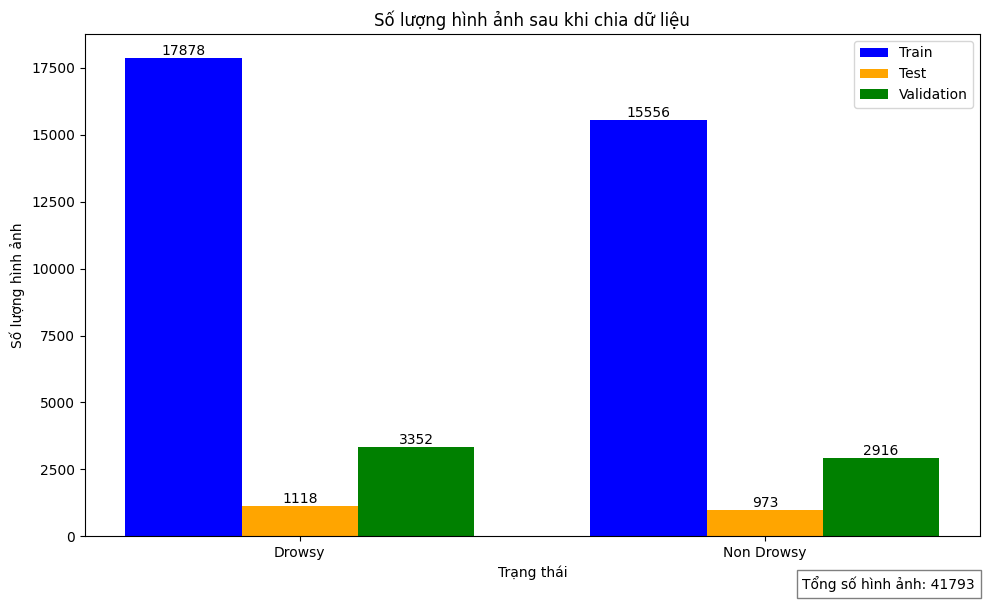

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn tới thư mục chứa dữ liệu
base_dir = '/kaggle/working/Dataset2'
folders = ['train', 'test', 'val']

# Danh sách các trạng thái
states = ['Drowsy', 'Non Drowsy']

# Tạo một từ điển để lưu số lượng hình ảnh cho mỗi trạng thái theo từng thư mục
image_count = {folder: {state: 0 for state in states} for folder in folders}

# Duyệt qua từng thư mục (train, test, val)
for folder in folders:
    folder_path = os.path.join(base_dir, folder)

    for state in states:
        state_path = os.path.join(folder_path, state)

        # Kiểm tra xem thư mục tồn tại hay không
        if os.path.exists(state_path):
            # Đếm số lượng tệp hình ảnh trong thư mục
            image_count[folder][state] = len([f for f in os.listdir(state_path) if os.path.isfile(os.path.join(state_path, f))])
        else:
            print(f"Thư mục '{state_path}' không tồn tại.")

# Tính tổng số lượng hình ảnh cho mỗi trạng thái
total_counts = {state: sum(image_count[folder][state] for folder in folders) for state in states}

# Tính tổng số lượng hình ảnh cho tất cả các tệp
overall_total = sum(total_counts.values())  # Tổng số lượng hình ảnh cho tất cả trạng thái

# Chuẩn bị dữ liệu cho biểu đồ
labels = list(image_count[folders[0]].keys())
train_counts = [image_count['train'][state] for state in labels]
test_counts = [image_count['test'][state] for state in labels]
val_counts = [image_count['val'][state] for state in labels]

x = np.arange(len(labels))  # Vị trí của các trạng thái
width = 0.25  # Chiều rộng của mỗi cột

# Vẽ biểu đồ cột nhóm
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width, train_counts, width, label='Train', color='blue')
bars2 = plt.bar(x, test_counts, width, label='Test', color='orange')
bars3 = plt.bar(x + width, val_counts, width, label='Validation', color='green')

# Thêm nhãn cho từng cột
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Hiển thị tổng số lượng hình ảnh cho tất cả trạng thái
plt.figtext(0.98, 0.01,
            f'Tổng số hình ảnh: {overall_total}',
            horizontalalignment='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Thiết lập nhãn và tiêu đề
plt.xlabel('Trạng thái')
plt.ylabel('Số lượng hình ảnh')
plt.title('Số lượng hình ảnh sau khi chia dữ liệu')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


##Specify test, train, val paths

In [ ]:
train = "/kaggle/working/Dataset2/train"
test = "/kaggle/working/Dataset2/test"
validation = "/kaggle/working/Dataset2/val"

## Enhance photos

In [ ]:
train_datagen = data_augment(
    rescale=1./255,
    brightness_range=[0.8, 1.2],           # Điều chỉnh độ sáng ảnh
    rotation_range=20,                     # Xoay ảnh trong khoảng ±20 độ
    width_shift_range=0.2,                 # Dịch chuyển ảnh theo chiều ngang tối đa 20%
    height_shift_range=0.2,                # Dịch chuyển ảnh theo chiều dọc tối đa 20%
    zoom_range=[0.8, 1.2],                 # Phóng to/thu nhỏ ảnh trong khoảng 80-120%
    horizontal_flip=True,                  # Lật ngang ảnh
    fill_mode='nearest'                    # Điền phần thiếu bằng giá trị gần nhất sau khi dịch chuyển
)

# Dữ liệu kiểm tra và xác thực thường không cần tăng cường chỉ cần chuẩn hóa
test_datagen = data_augment(rescale=1./255)
val_datagen = data_augment(rescale=1./255)

##Create batches of data

In [ ]:
train_batches = train_datagen.flow_from_directory(
    train,                            # Đường dẫn đến thư mục chứa tập huấn luyện
    target_size=(224, 224),           # Kích thước ảnh
    batch_size=64,                    # Phù hợp với bộ nhớ, có thể giảm nếu cần
    class_mode='binary',              # Nhãn nhị phân
    shuffle=True                      # Đảo trộn dữ liệu cho mỗi epoch
)

test_batches = test_datagen.flow_from_directory(
    test,                             # Đường dẫn đến thư mục chứa tập kiểm tra
    target_size=(224, 224),           # Kích thước ảnh
    batch_size=64,                    # Sử dụng batch_size giống tập huấn luyện nếu bộ nhớ đủ
    class_mode='binary',              # Nhãn nhị phân
    shuffle=False                     # Không đảo trộn khi kiểm tra
)

val_batches = val_datagen.flow_from_directory(
    validation,                       # Đường dẫn đến thư mục chứa tập xác nhận
    target_size=(224, 224),           # Kích thước ảnh
    batch_size=64,                    # Sử dụng batch_size giống tập huấn luyện nếu bộ nhớ đủ
    class_mode='binary',              # Nhãn nhị phân
    shuffle=True                      # Đảo trộn dữ liệu cho mỗi epoch
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


## Class number

In [ ]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


## Image after normalization + enhancement

Pixels of the first image after Normalization: 

[[[0.0509804  0.05490196 0.0627451 ]
  [0.0509804  0.0509804  0.05490196]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.5803922  0.5764706  0.5411765 ]
  [0.58431375 0.5764706  0.5411765 ]
  [0.58431375 0.5764706  0.5411765 ]]

 [[0.0509804  0.0509804  0.0627451 ]
  [0.0509804  0.0509804  0.05882353]
  [0.03921569 0.03921569 0.03921569]
  ...
  [0.58431375 0.5764706  0.5411765 ]
  [0.5882353  0.5764706  0.5411765 ]
  [0.5882353  0.5764706  0.5411765 ]]

 [[0.0509804  0.0509804  0.0627451 ]
  [0.0509804  0.05490196 0.0627451 ]
  [0.04313726 0.04313726 0.04313726]
  ...
  [0.5882353  0.5764706  0.5411765 ]
  [0.5882353  0.5764706  0.5372549 ]
  [0.5882353  0.5764706  0.5372549 ]]

 ...

 [[0.5647059  0.54901963 0.52156866]
  [0.5647059  0.54901963 0.52156866]
  [0.5647059  0.54901963 0.52156866]
  ...
  [0.8745099  0.8745099  0.854902  ]
  [0.8745099  0.8745099  0.854902  ]
  [0.8745099  0.8745099  0.854902  ]]

 [[0.5647059  0.54509807 

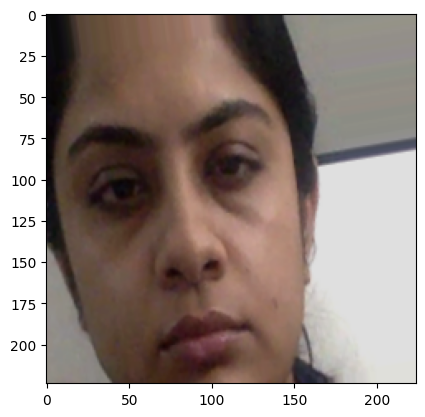

In [ ]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()


##Photo parameters

In [ ]:
if images[0].ndim == 3 and images[0].shape[2] == 3:
    print("The image is a color image (RGB).")
elif images[0].ndim == 3 and images[0].shape[2] == 1:
    print("The image is a grayscale image.")
else:
    print("Unexpected image format.")

print(f"Batch size: {images.shape[0]}")  # Số lượng bức ảnh trong batch
print(f"Shape of all images in batch: {images.shape}")  # Hình dạng của tất cả ảnh trong batch

print(f"Data type of the first image: {images[0].dtype}")  # Kiểu dữ liệu của bức ảnh

The image is a color image (RGB).
Batch size: 64
Shape of all images in batch: (64, 224, 224, 3)
Data type of the first image: float32


## Photos in train folder

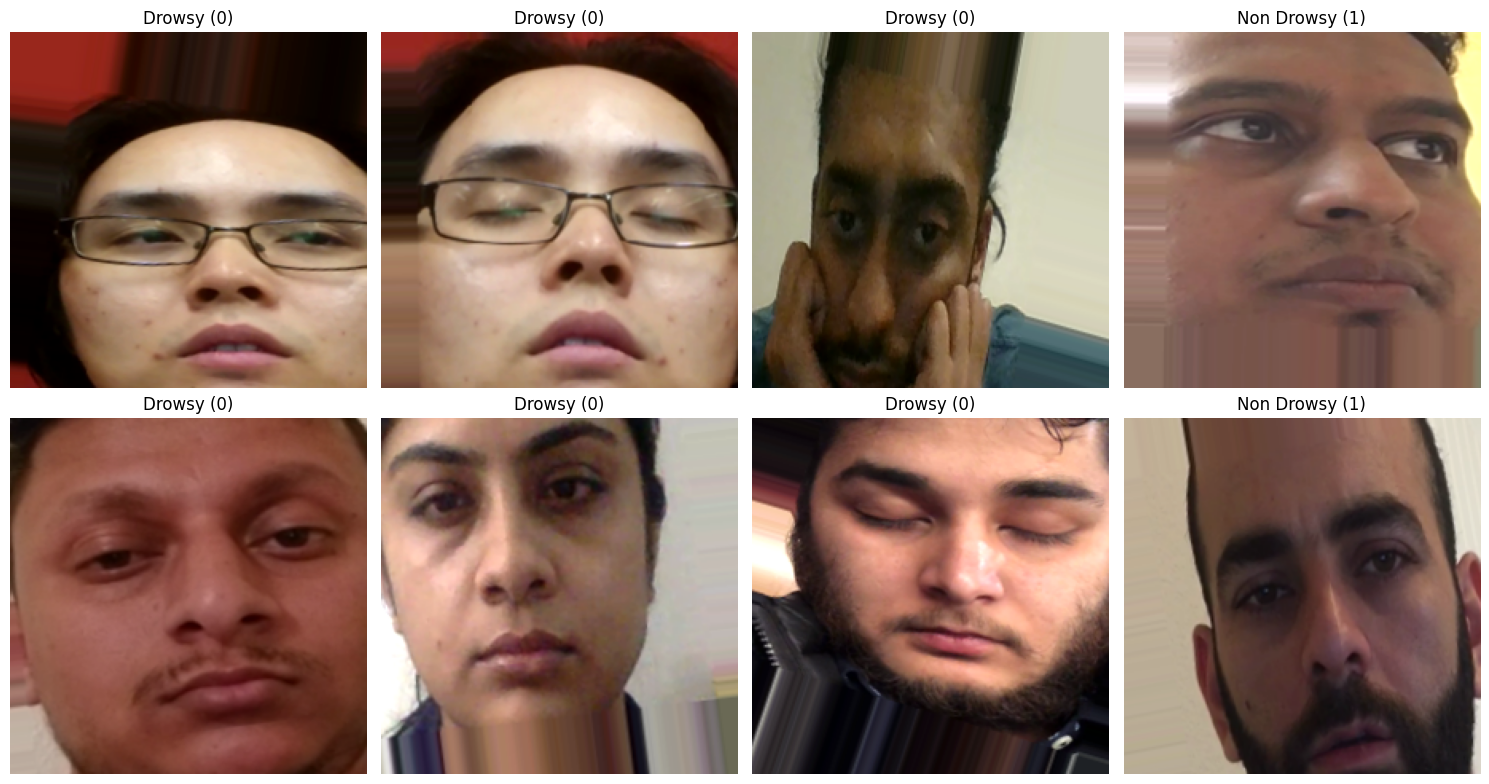

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
class_indices = train_batches.class_indices

for i in range(2):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

## Config DenseNet201

In [ ]:
# Khởi tạo mô hình DenseNet-201
model_base = DenseNet201(
    weights='imagenet',  # Sử dụng trọng số được huấn luyện sẵn trên ImageNet
    include_top=False,  # Không bao gồm lớp phân loại cuối cùng
    input_shape=(224, 224, 3)  # Kích thước đầu vào
)

# Đóng băng tất cả các lớp của DenseNet-201
for layer in model_base.layers:
    layer.trainable = False

# Mở khóa các lớp cuối cùng (ví dụ, mở khóa 3 lớp cuối)
n = 3
for layer in model_base.layers[-n:]:
    layer.trainable = True

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Layer structure of the DenseNet201 model

In [ ]:
#Hien thi kien truc model Model: DenseNet201

model_base.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 3,840 (15.00 KB)

 Non-trainable params: 18,318,144 (69.88 MB)

## Add classification layers + checkpoint + early_stopping

In [ ]:
# Thêm các tầng phân loại
x = model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # 2 lớp đầu ra

# Tạo mô hình hoàn chỉnh
model = Model(inputs=model_base.input, outputs=output)

# Khởi tạo các callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint('/kaggle/working/Model/best.keras', monitor='val_loss', save_best_only=True, mode='min')

# Biên dịch mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Structure of the model's layers

In [ ]:
# Cấu trúc các lớp sau khi kết hợp
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,814,914 (79.40 MB)

 Trainable params: 2,496,770 (9.52 MB)

 Non-trainable params: 18,318,144 (69.88 MB)

## Model training

In [ ]:
import time

# Bắt đầu đếm thời gian
start_time = time.time()

# Huấn luyện mô hình
history = model.fit(
    train_batches,   # Dữ liệu huấn luyện
    epochs=20,       # Số lượng epochs
    validation_data=val_batches,  # Dữ liệu kiểm tra
    callbacks=[early_stopping, reduce_lr, checkpoint]  # Các callback để theo dõi và điều chỉnh quá trình huấn luyện
)

# Tính toán thời gian huấn luyện
end_time = time.time()
training_time = end_time - start_time

# In ra tổng thời gian huấn luyện
print(f"Tổng thời gian huấn luyện: {training_time:.2f} giây")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731416500.185351     137 service.cc:145] XLA service 0x7aa1b4002fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731416500.185406     137 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/523 ━━━━━━━━━━━━━━━━━━━━ 8:16:44 57s/step - accuracy: 0.5781 - loss: 0.7754

I0000 00:00:1731416527.669119     137 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731416527.708771     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/523 ━━━━━━━━━━━━━━━━━━━━ 6:00 1s/step - accuracy: 0.6180 - loss: 0.6835

I0000 00:00:1731416768.608629     137 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_1', 4 bytes spill stores, 4 bytes spill loads



523/523 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.6966 - loss: 0.5717 - val_accuracy: 0.9721 - val_loss: 0.1159 - learning_rate: 1.0000e-04
Epoch 2/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - accuracy: 0.9186 - loss: 0.2011 - val_accuracy: 0.9904 - val_loss: 0.0418 - learning_rate: 1.0000e-04
Epoch 3/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.9612 - loss: 0.1059 - val_accuracy: 0.9896 - val_loss: 0.0356 - learning_rate: 1.0000e-04
Epoch 4/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.9735 - loss: 0.0749 - val_accuracy: 0.9960 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 5/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.9789 - loss: 0.0590 - val_accuracy: 0.9944 - val_loss: 0.0184 - learning_rate: 1.0000e-04
Epoch 6/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.9840 - loss: 0.0462 - val_accuracy: 0.9955 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 7/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 575s 1s/step - accuracy: 0.98

## SAVE MODEL

In [ ]:
# Lưu mô hình trong định dạng .keras
model.save('/kaggle/working/model2.keras')

## Evaluation on the train set

In [ ]:
train_loss, train_acc = model.evaluate(train_batches)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

523/523 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.9989 - loss: 0.0035
Training Loss: 0.0031
Training Accuracy: 99.91%


I0000 00:00:1731428692.625581     140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads



## Evaluation on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 768ms/step - accuracy: 0.9998 - loss: 6.3645e-04
Test Loss: 0.0011
Test Accuracy: 99.95%


## Accuracy chart and loss chart

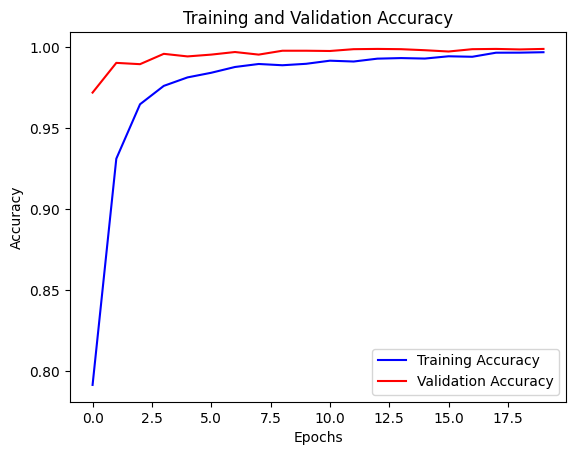

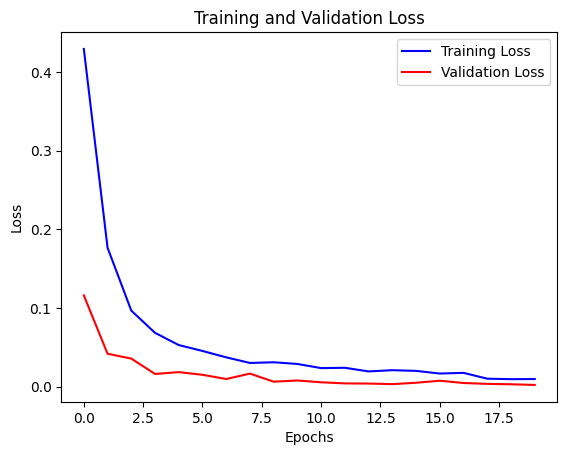

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Vẽ và lưu biểu đồ Độ chính xác (Accuracy)
plt.figure()
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig("training_validation_accuracy.png")  # Lưu biểu đồ thành file PNG
plt.show()

# Vẽ và lưu biểu đồ Mất mát (Loss)
plt.figure()
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("training_validation_loss.png")  # Lưu biểu đồ thành file PNG
plt.show()


## Create confusion matrix

In [ ]:
from keras.models import load_model
from PIL import Image
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Tải mô hình
model = load_model('/kaggle/working/model2.keras')

# Đường dẫn đến các thư mục test
test_dirs = {
    'Drowsy': '/kaggle/working/Dataset2/test/Drowsy',
    'Non Drowsy': '/kaggle/working/Dataset2/test/Non Drowsy'
}

# Lưu trữ kết quả
y_true = []  # Nhãn thực tế
y_pred = []  # Dự đoán của mô hình

# Duyệt qua từng thư mục
for label, test_dir in test_dirs.items():
    true_label = 0 if label == 'Drowsy' else 1

    for img_file in os.listdir(test_dir):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            # Tải ảnh
            image_path = os.path.join(test_dir, img_file)
            image = Image.open(image_path)

            # Thay đổi kích thước ảnh theo yêu cầu của mô hình
            image_resized = image.resize((224, 224))
            image_array = np.array(image_resized)

            # Chuẩn hóa dữ liệu
            image_array = image_array / 255.0
            image_array = image_array.reshape(1, 224, 224, 3)

            # Dự đoán
            predictions = model.predict(image_array)
            class_index = np.argmax(predictions[0])
            y_pred.append(class_index)

            # Lưu nhãn thực tế
            y_true.append(true_label)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

# Hiển thị số lượng đúng và sai
correct_predictions = cm[0, 0] + cm[1, 1]
incorrect_predictions = cm[0, 1] + cm[1, 0]
print(f"Số lượng dự đoán đúng: {correct_predictions}")
print(f"Số lượng dự đoán sai: {incorrect_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

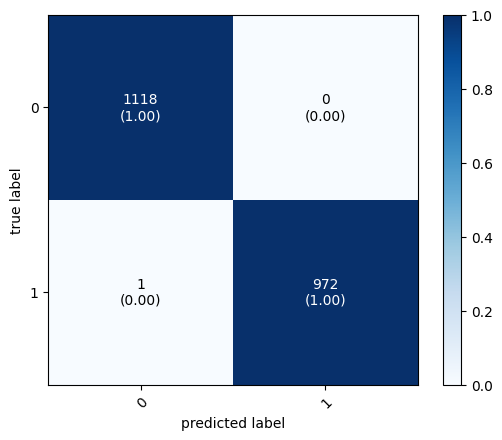

In [ ]:
# Vẽ ma trận nhầm lẫn
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True,
                                  show_normed=True, colorbar=True,
                                  class_names=['0', '1'])
plt.show()

## Visualize the architecture of a deep learning model

In [ ]:
!pip install --upgrade visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.4 MB/s eta 0:00:00 0:00:01


/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpwqy4leqm.PNG'
/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacin

## Test model

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Tỷ lệ dự đoán:
Lớp 0 (Drowsy): 0.00%
Lớp 1 (Non Drowsy): 100.00%


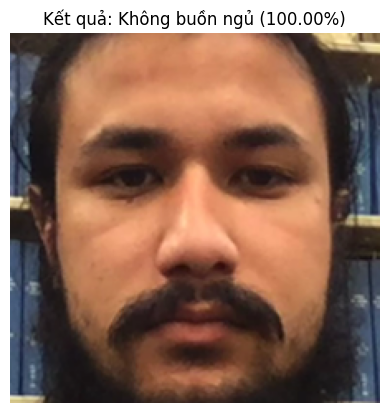

In [23]:
from keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Tải mô hình
model = load_model('/content/drive/MyDrive/Colab Notebooks/DenseNet201/densenet201.keras')

# Đường dẫn đến ảnh
image_path = '/content/drive/MyDrive/Colab Notebooks/Test/Non Drowsy/q0081.png'

# Tải ảnh
image = Image.open(image_path)

# Thay đổi kích thước ảnh theo yêu cầu của mô hình (ví dụ: 224x224)
image_resized = image.resize((224, 224))  # Thay đổi kích thước theo mô hình của bạn
image_array = np.array(image_resized)

# Nếu cần, chuẩn hóa dữ liệu (giả sử mô hình yêu cầu dữ liệu từ 0-1)
image_array = image_array / 255.0  # Chia cho 255 nếu giá trị pixel từ 0-255

# Thêm một chiều cho batch size
image_array = image_array.reshape(1, 224, 224, 3)  # Thay đổi kích thước theo mô hình của bạn

# Dự đoán
predictions = model.predict(image_array)

# Hiển thị tỷ lệ dự đoán
print("Tỷ lệ dự đoán:")
for i, prob in enumerate(predictions[0]):
    if i == 0:
      print(f"Lớp {i} (Drowsy): {prob * 100:.2f}%")  # Hiển thị tỷ lệ phần trăm với 2 chữ số thập phân
    else:
      print(f"Lớp {i} (Non Drowsy): {prob * 100:.2f}%")  # Hiển thị tỷ lệ phần trăm với 2 chữ số thập phân

# Xác định lớp dự đoán
class_index = np.argmax(predictions[0])  # Lấy chỉ số lớp với xác suất cao nhất

# Hiển thị kết quả dựa trên lớp
if class_index == 0:
    result = "Buồn ngủ"
else:
    result = "Không buồn ngủ"


# Hiển thị ảnh
plt.imshow(image_resized)
plt.title(f"Kết quả: {result} ({predictions[0][class_index] * 100:.2f}%)")
plt.axis('off')  # Tắt hiển thị trục
plt.show()


## Create Grad-CAM

In [10]:
%matplotlib inline

In [11]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

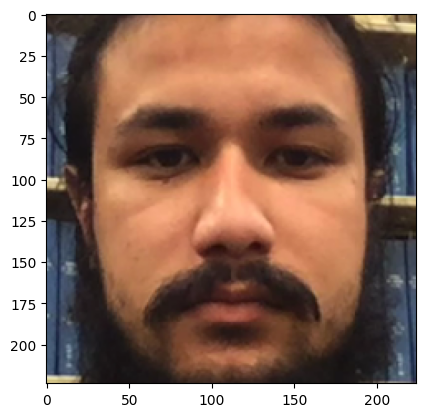

In [13]:
image = np.array(load_img("/content/drive/MyDrive/Colab Notebooks/Test/Non Drowsy/q0081.png", target_size=(224, 224, 3)))
plt.imshow(image)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/DenseNet201/densenet201.keras')

In [15]:
last_conv_layer = model.get_layer("conv5_block31_concat")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [16]:
# Giả sử `last_conv_layer` là lớp cuối cùng của phần convolution trong mô hình
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])

# Làm phẳng đầu ra từ convolution
x = tf.keras.layers.Flatten()(classifier_input)

# Thêm một lớp Dense để giảm kích thước đầu vào thành 128 (hoặc số lượng cần thiết)
x = tf.keras.layers.Dense(1920, activation='relu')(x)

# Lấy lớp "dense" từ mô hình (nếu cần, hoặc tạo một lớp dense khác)
x = model.get_layer("dense")(x)

# Tạo mô hình phân loại cuối cùng
classifier_model = tf.keras.Model(classifier_input, x)

In [17]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [18]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [19]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [20]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [21]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (224, 224))

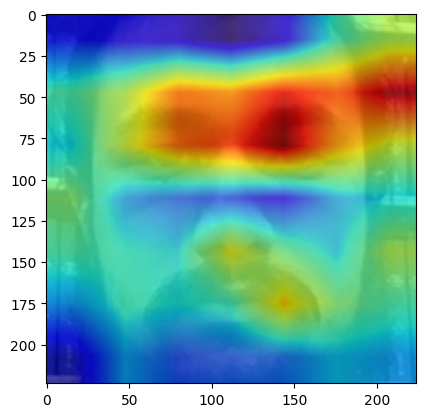

In [22]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.7, cmap='jet')
plt.show()

## Activation maps

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Đường dẫn đến ảnh bạn muốn dùng
img_path = '/content/drive/MyDrive/Colab Notebooks/Data_Split/test/Drowsy/image_0371.jpg'  # Thay 'path_to_your_image.jpg' bằng đường dẫn của ảnh

# Kích thước đầu vào của ảnh (thay IMG_HEIGHT và IMG_WIDTH theo mô hình của bạn)
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Ví dụ kích thước, thay đổi theo mô hình bạn đang dùng

# Nạp ảnh và chuyển đổi thành mảng numpy
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
img_array = img_array / 255.0  # Chuẩn hóa nếu cần


In [ ]:
# Lấy các layer bạn muốn quan sát
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

# Lấy kết quả từ tất cả các layer
activations = activation_model.predict(img_array)

# Hiển thị các activation maps cho từng lớp
for layer_name, layer_activation in zip([layer.name for layer in model.layers if 'conv' in layer.name], activations):
    print(f"Layer: {layer_name}")
    num_filters = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # Số bộ lọc cần hiển thị
    display_filters = min(num_filters, 8)  # Hiển thị tối đa 8 bộ lọc để dễ nhìn

    # Vẽ một vài kênh đầu ra
    fig, ax = plt.subplots(1, display_filters, figsize=(20, 20))
    for i in range(display_filters):
        ax[i].imshow(layer_activation[0, :, :, i], cmap='viridis')
        ax[i].axis('off')

    plt.show()


Output hidden; open in https://colab.research.google.com to view.